In [1]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"

In [2]:
sources = ["gurufocus/", "seekingAlpha.seekingAlphaBulkMetrics/"]

dfs_19 = [wr.s3.read_parquet(s3_collection_path + s + "2023-09-19.parquet", boto3_session=session) for s in sources]
dfs_26 = [wr.s3.read_parquet(s3_collection_path + s + "2023-09-26.parquet", boto3_session=session) for s in sources]

# df_2023_09_19 = wr.s3.read_parquet(s3_collection_path + "2023-09-19.parquet", boto3_session=session)
# df_2023_09_26 = wr.s3.read_parquet(s3_collection_path + "2023-09-26.parquet", boto3_session=session)


In [3]:
dfs_19[0].head()

,symbol,growth_rank,3-Year_Revenue_Growth_Rate,3-Year_EBITDA_Growth_Rate,3-Year_EPS_without_NRI_Growth_Rate,3-Year_FCF_Growth_Rate,3-Year_Book_Growth_Rate,Future_3-5Y_Total_Revenue_Growth_Rate,profitability_rank,Gross_Margin_%,...,Price-to-DCF__Earnings_Based_,Price-to-Median-PS-Value,Price-to-Peter-Lynch-Fair-Value,Price-to-Graham-Number,Price-to-Net-Current-Asset-Value,Price-to-Net-Cash,Price-to-Owner-Earnings,Price-to-Free-Cash-Flow,Price-to-FFO,Price-to-DCF__FCF_Based_
0,AA,0.4,6.8,54.4,51.8,4.4,9.0,-0.36,0.5,6.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAP,0.7,10.4,8.0,6.5,-4.2,-4.1,1.54,0.8,43.58,...,0.89,0.27,1.24,1.20,NaN,NaN,NaN,NaN,NaN,NaN
2,ABCL,NaN,215.7,NaN,NaN,NaN,631.1,NaN,0.5,88.57,...,NaN,NaN,NaN,NaN,2.48,3.22,NaN,NaN,NaN,NaN
3,ABCM,0.7,13.9,-22.7,NaN,NaN,22.7,18.15,0.8,75.88,...,NaN,0.74,NaN,39.74,NaN,NaN,NaN,NaN,NaN,NaN
4,ABEV,0.7,15.3,5.3,7.1,2.0,10.1,6.69,0.9,49.95,...,NaN,0.44,NaN,1.94,NaN,NaN,16.7,14.71,NaN,NaN


In [4]:
overlapped_tickers = dfs_19[1]["ticker"][dfs_19[1]["ticker"].isin(dfs_26[1]["ticker"])]


In [5]:
guru_19 = dfs_19[0].set_index("symbol").loc[overlapped_tickers]
guru_26 = dfs_26[0].set_index("symbol").loc[overlapped_tickers]

alpha_19 = dfs_19[1].set_index("ticker").loc[overlapped_tickers]
alpha_26 = dfs_26[1].set_index("ticker").loc[overlapped_tickers]

In [6]:
df_19 = pd.concat([guru_19, alpha_19], axis = 1).select_dtypes("float")

In [7]:
df_26 = pd.concat([guru_26, alpha_26], axis = 1).select_dtypes("float")

In [8]:
df_19.corrwith(df_26).describe()

count    330.000000
mean       0.982506
std        0.076800
min        0.310832
25%        0.997132
50%        0.999887
75%        0.999996
max        1.000000
dtype: float64

In [9]:
df_19.corrwith(df_26).sort_values()

Earnings_Yield__Greenblatt__%    0.310832
ev_ebit_fy1                      0.378230
last_price_vs_sma_10d            0.394811
5-Day_RSI                        0.473860
peg_nongaap_fy1                  0.634679
                                   ...   
3-Year_Revenue_Growth_Rate       1.000000
eps_gaap_annual_growth_yoy       1.000000
sustainable_growth_rate          1.000000
3-Year_FCF_Growth_Rate           1.000000
peg_gaap_avg_5y                       NaN
Length: 331, dtype: float64

In [10]:
df_19.isna().sum().describe()

count     331.000000
mean      302.897281
std       276.459326
min         0.000000
25%        53.000000
50%       215.000000
75%       552.000000
max      1057.000000
dtype: float64

In [11]:
price_diff = df_26["primary_price"] - df_19["primary_price"]
price_diff_pct = price_diff / df_19["primary_price"]
price_diff_pct.tail()

ZNTL   -0.077368
ZS     -0.037164
ZTO    -0.028343
ZUO    -0.036824
ZWS    -0.014565
Name: primary_price, dtype: float64

In [12]:
X = df_19.copy()
X["target"] = price_diff_pct

In [13]:
# What correlates the most with the target variable?
feature_target_corr = X.corr()["target"].sort_values()
feature_target_corr

beta24                            -0.301661
coefficient_of_variation_90d      -0.273251
short_interest_percent_of_float   -0.241841
p_week_vol_shares                 -0.187265
3-Year_Revenue_Growth_Rate        -0.180957
                                     ...   
profitability_rank                 0.237251
return_on_total_capital            0.256354
cf_payout_avg_5y                   0.443166
target                             1.000000
peg_gaap_avg_5y                         NaN
Name: target, Length: 332, dtype: float64

In [14]:
feature_target_corr.tail(20)

return_on_total_capital_avg_5y        0.150472
ebitda_margin                         0.154197
diluted_eps                           0.154245
ebit_margin                           0.155126
levered_fcf_margin                    0.157841
Earnings_Yield__Greenblatt__%         0.159189
earn_yield_gaap_fy1                   0.161375
net_lt_debt_tot_assets_avg_5y         0.163731
ROE_%                                 0.177245
3-Year_EBITDA_Growth_Rate             0.178879
eps_estimate                          0.191914
return_on_avg_tot_assets              0.205067
ROA_%                                 0.215810
ROCE_%                                0.222657
3-Year_EPS_without_NRI_Growth_Rate    0.235203
profitability_rank                    0.237251
return_on_total_capital               0.256354
cf_payout_avg_5y                      0.443166
target                                1.000000
peg_gaap_avg_5y                            NaN
Name: target, dtype: float64

In [15]:
feature_target_corr_spearman = X.corr(method = "spearman")["target"].sort_values()
feature_target_corr_spearman

beta24                            -0.291399
ps_ratio_avg_5y                   -0.224339
ev_12m_sales_ratio_avg_5y         -0.220358
short_interest_percent_of_float   -0.217066
ev_ebit_fy1_avg_5y                -0.212758
                                     ...   
int_cover                          0.323999
return_on_total_capital            0.331165
cf_payout_avg_5y                   0.545320
target                             1.000000
peg_gaap_avg_5y                         NaN
Name: target, Length: 332, dtype: float64

In [17]:
feature_target_corr_spearman.head(20)

beta24                            -0.291399
ps_ratio_avg_5y                   -0.224339
ev_12m_sales_ratio_avg_5y         -0.220358
short_interest_percent_of_float   -0.217066
ev_ebit_fy1_avg_5y                -0.212758
ev_12m_sales_ratio                -0.209231
EV-to-Revenue                     -0.208287
ev_ebit_fy1                       -0.200193
ev_sales_fy1                      -0.199058
ev_sales_fy1_avg_5y               -0.195333
ev_ebitda_fy1                     -0.192411
ps_ratio_fy1_avg_5y               -0.190669
Cash_Ratio                        -0.184408
ps_ratio                          -0.181520
ps_ratio_fy1                      -0.181358
capex_change_avg_5y               -0.180312
revenue_change_display_avg_5y     -0.178451
current_ratio                     -0.177691
PS_Ratio                          -0.175568
ev_ebit_avg_5y                    -0.169803
Name: target, dtype: float64

In [18]:
"""
Relatively important feature definitions

POSITIVE CORRELATION:

Earnings_Yield__Greenblatt__%: Operating Income divided by Enterprise Value (https://www.valuesignals.com/Glossary/Details/Earnings_Yield)
3-Year_EPS_without_NRI_Growth_Rate: 3-year Earnings per share without NRI (Non-Recurring Item) Growth Rate
levered_fcf_margin: Amount of Free Cash Flow a company has after paying all financial obligations
ROIC_%: Return on Invested Capital
ROCE_%: Return on Capital Employed
ROA_%: Return on Assets
ROE_%: Return on Equity
int_cover: Interest Coverage
cf_payout_avg_5y: Cash Flow Payout Ratio Average 5 years
return_on_avg_tot_assets: Return on Average Total Assets
return_on_total_capital: Return on Total Capital
eps_estimate: Earnings per Share estimate
ebitda: Earnings before Interests, Taxes, Depreciation, and Amoritization
net_income: Net Income
net_inc_per_employee: Net income per employee
tev: Total Enterprise Valuation
total_revenue: Total Revenue
total_cash: Total Cash

NEGATIVE CORRELATION:

beta24: Expected move in stock relative to market (higher beta means more similar to market)
short_interest_percent_of_float: Short Interest Percent
ps_ratio_avg_5y: Price to Sales ratio Average 5 years
net_lt_debt_tot_assets_avg_5y: Net long term debt over total assets (average 5 years)
ev_12m_sales_ratio: Enterprise Value (12 months) to Sales
EV-to-Revenue: Enterprise Value to Revenue
Cash_Ratio: Measures liquidity based on whether company can cover short term obligations using only cash
"""
positive_features = [
	"int_cover", "cf_payout_avg_5y", "return_on_avg_tot_assets", "return_on_total_capital",
	"eps_estimate", "ebitda", "net_income", "net_inc_per_employee", "tev", "total_revenue", "total_cash",
	"Earnings_Yield__Greenblatt__%", "ROIC_%", "ROCE_%", "ROA_%", "ROE_%", "levered_fcf_margin"]

negative_features = [
	"beta24", "short_interest_percent_of_float", "ps_ratio_avg_5y", "net_lt_debt_tot_assets_avg_5y", "ev_12m_sales_ratio",
	"EV-to-Revenue", "Cash_Ratio",
]

Text(0.5, 1.0, 'Distribution of pearson correlation with target')

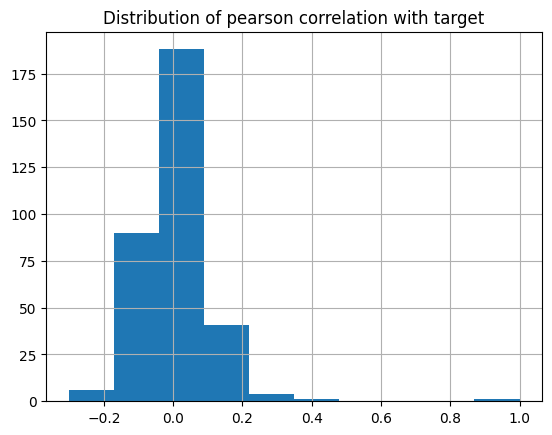

In [19]:
import matplotlib.pyplot as plt
X.corr(method = "pearson")["target"].hist()
plt.title("Distribution of pearson correlation with target")

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [41]:
y = X["target"]
X_ = X[positive_features + negative_features]
# X_ = X[positive_features]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_.fillna(0.), y, shuffle=True, train_size=.8)

X_train = normalize(X_train)
X_test = normalize(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

print("Train score:")
print(linreg.score(X_train, y_train))
print("Test score:")
print(linreg.score(X_test, y_test))

Train score:
0.12608948627969696
Test score:
-2539379268013.199


In [43]:
pd.DataFrame(list(zip(X_.columns, linreg.coef_))).sort_values(1, ascending = False)

,0,1
14,ROA_%,8.556898e+05
23,Cash_Ratio,3.624273e+05
3,return_on_total_capital,2.807859e+05
20,net_lt_debt_tot_assets_avg_5y,2.441712e+05
22,EV-to-Revenue,2.415789e+04
12,ROIC_%,5.525743e+03
16,levered_fcf_margin,3.736191e+03
5,ebitda,8.750921e-02
6,net_income,4.614078e-02
9,total_revenue,1.677389e-02


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_.fillna(0.), y, shuffle=True, train_size=.8)

X_train = normalize(X_train)
X_test = normalize(X_test)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

print("Train score:")
print(forest.score(X_train, y_train))
print("Test score:")
print(forest.score(X_test, y_test))

Train score:
0.8592606585320695
Test score:
-0.06178106094276692


In [45]:
pd.DataFrame(list(zip(X_.columns, forest.feature_importances_))).sort_values(1, ascending = False)

,0,1
5,ebitda,0.243903
7,net_inc_per_employee,0.148102
6,net_income,0.148002
9,total_revenue,0.140316
10,total_cash,0.131661
8,tev,0.108226
0,int_cover,0.025199
15,ROE_%,0.012193
16,levered_fcf_margin,0.011974
22,EV-to-Revenue,0.010981


In [46]:
# Try as classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [47]:
y_ = np.float32(y > 0.)

X_train, X_test, y_train, y_test = train_test_split(X_.fillna(0.), y_, shuffle=True, train_size=.8)

X_train = normalize(X_train)
X_test = normalize(X_test)

linreg = LogisticRegression()
linreg.fit(X_train, y_train)

print("Train score:")
print(linreg.score(X_train, y_train))
print("Test score:")
print(linreg.score(X_test, y_test))

Train score:
0.8037825059101655
Test score:
0.7971698113207547


In [48]:
pd.DataFrame(list(zip(X_.columns, linreg.coef_[0]))).sort_values(1, ascending = False)

,0,1
5,ebitda,7.443833e-01
9,total_revenue,7.359892e-01
8,tev,4.052427e-01
21,ev_12m_sales_ratio,2.720313e-06
16,levered_fcf_margin,1.453690e-06
19,ps_ratio_avg_5y,1.097603e-06
3,return_on_total_capital,1.006490e-07
17,beta24,-4.142468e-09
1,cf_payout_avg_5y,-4.261452e-09
18,short_interest_percent_of_float,-1.950010e-08


In [49]:
y_ = np.float32(y > 0.)

X_train, X_test, y_train, y_test = train_test_split(X_.fillna(0.), y_, shuffle=True, train_size=.8)

X_train = normalize(X_train)
X_test = normalize(X_test)

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

print("Train score:")
print(forest.score(X_train, y_train))
print("Test score:")
print(forest.score(X_test, y_test))

Train score:
0.9468085106382979
Test score:
0.7783018867924528


In [50]:
pd.DataFrame(list(zip(X_.columns, forest.feature_importances_))).sort_values(1, ascending=False)

,0,1
10,total_cash,0.171597
9,total_revenue,0.171116
5,ebitda,0.155399
6,net_income,0.152751
8,tev,0.145612
7,net_inc_per_employee,0.140851
0,int_cover,0.027584
22,EV-to-Revenue,0.012418
16,levered_fcf_margin,0.007610
21,ev_12m_sales_ratio,0.004454


In [51]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    # plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    # plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    return fig

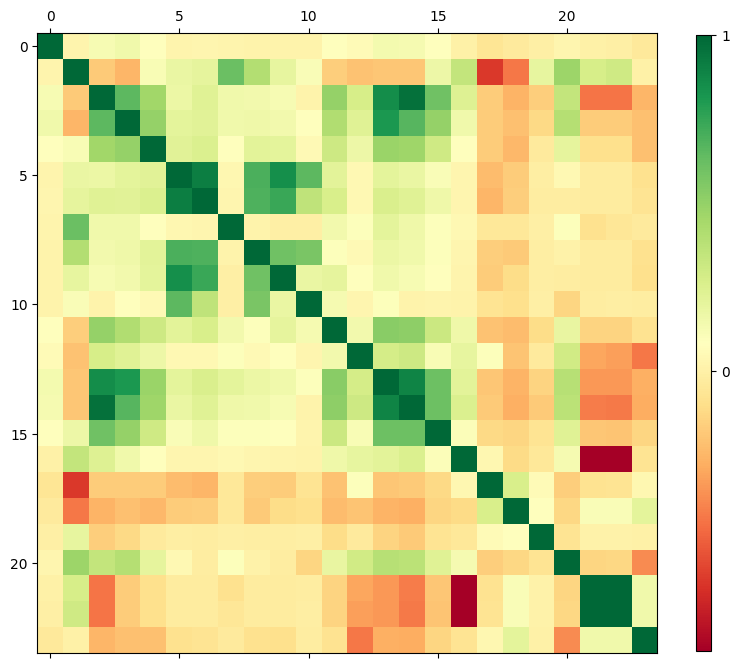

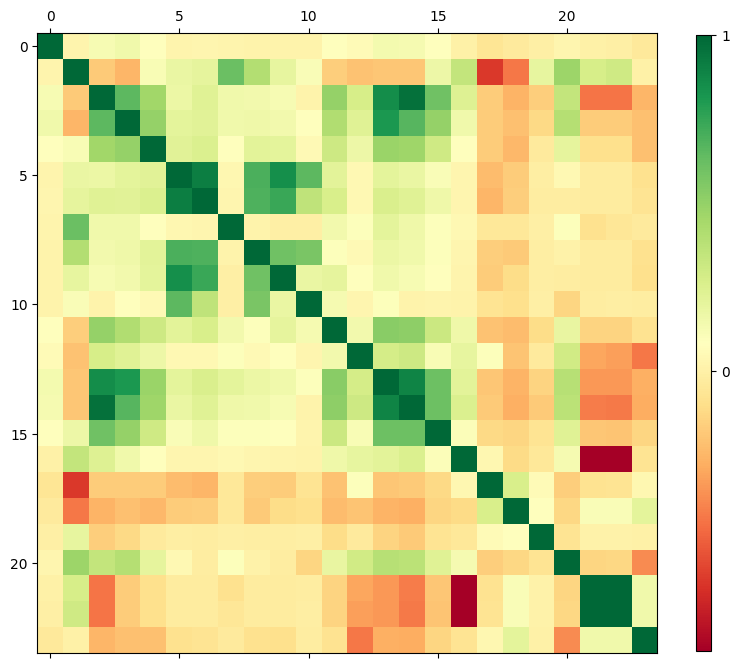

In [53]:
plot_corr(X_)

In [54]:
# Source: https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb

import scipy
import numpy as np
import scipy.cluster.hierarchy as sch

float_df = df_19.fillna(0.)

X = float_df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [float_df.columns.tolist()[i] for i in list((np.argsort(ind)))]
float_df = float_df.reindex(columns = columns)

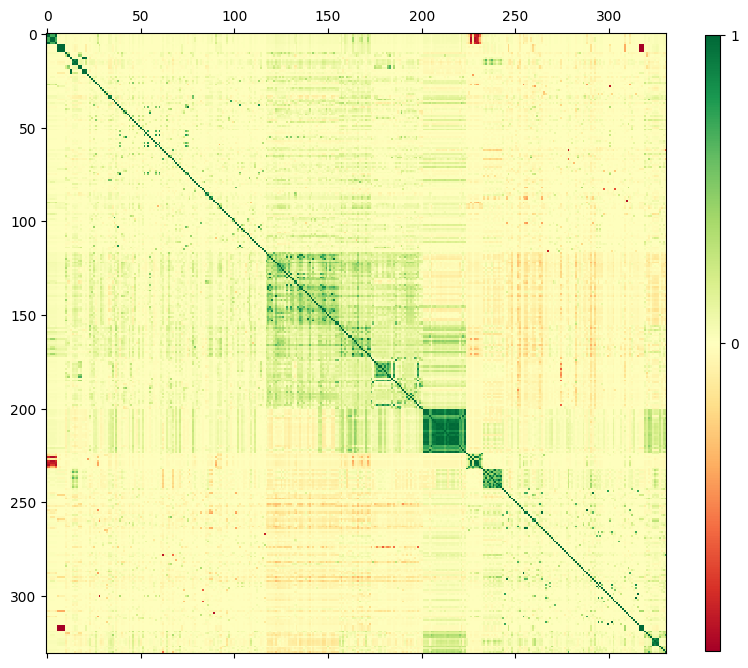

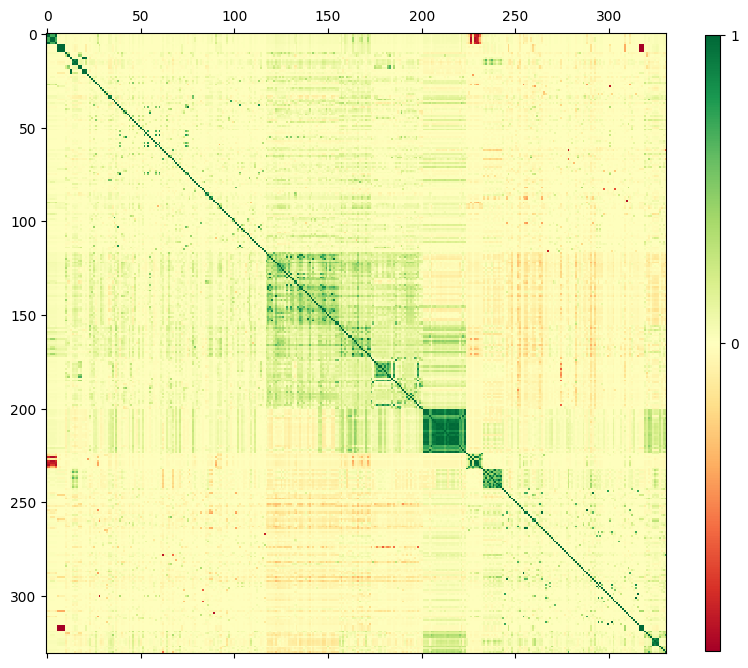

In [55]:
plot_corr(float_df)